LSE Data Science Institute | DS105A (2023/24) | Week 05

# 🗓️ Week 05: More Web scraping: CSS Selectors, XPaths and Pagination

Theme: Collecting Data

**DATE:** 22 October 2023

**AUTHOR:** [Alexander Soldatkin](https://github.com/alex-soldatkin) & Dr [Jon Cardoso-Silva](https://jonjoncardoso.github.io)

-----

**PRE-REQUISITES:**

To understand this notebook, you should first revisit the following notebooks: 

- 📚 Week 04 Appendix 01
- 🛣️ Week 04 Lab Roadmap

## ⚙️ Setup

In [1]:
import requests
from scrapy import Selector
import pandas as pd
from pprint import pprint
from tqdm.notebook import tqdm

If the above throws an error of module not found, uncomment the line below to install scrapy:

In [4]:
# !pip install scrapy

💡 Tip: alternatively, you can type this command in your terminal

**OBJECTIVE:**

In this tutorial, we will try to scrape [this page](https://www.lse.ac.uk/programmes/search-courses) from the LSE website which contains information on their courses. 

We will try to collect the following information for each course:

- title
- department
- course type
- start date
- duration
- location
- URL. 

# 1. The (X)Path to success

In the W04 labs, as well as in Appendix 01, we have seen how we can use CSS selectors to find elements in the HTML code of a webpage. However, there is another way to do this: **XPath**. 

<div style="width:70%;border: 1px solid #aaa; border-radius:1em; padding: 1em; margin: 1em 0;">

📕 **What is XPath?** 

XPath is a query language for selecting nodes from an XML language

 XPath is a bit more powerful than CSS selectors, but it is also a bit more complicated. It allows us more flexibility when it comes to finding the children or partents of certain elements. What's more, it you find yourself being able to get to a parent element with CSS but cannot get to its children because they have some obscure class name, XPath can be 'chained' at the end of a CSS element. 

</div>

## 1.1 Loading the page and getting the HTML

First, we send a GET request to the page to obtain a response object, with which we can get the HTML code of the page:

In [14]:
url = 'https://www.lse.ac.uk/programmes/search-courses?pageIndex=1'

# Load the first page
response = requests.get(url)

<div style="width:70%;border: 1px solid #aaa; border-radius:1em; padding: 1em; margin: 1em 0;">

💡 **PRO-TIP:** 

In reality, `requests.get(url)` is a shortening of `requests.request('GET', url)`.

Whenever we send a request to a server, we need to specify the type of request we are sending. The most common types are GET, which intuitively means that we are asking the server to send us some data, and POST, which means that we are sending some data to the server.


</div>

Right after collecting the page, it's a good practice to check if the request was successful. We can do this by checking the status code of the response:

In [15]:
# Check the status code, 200 means OK, anything else means something went wrong
if not response.status_code == 200:
    print('Something went wrong, status code:', response.status_code)
else:
    print('Everything is OK, status code:', response.status_code)

# print the HTML code
print(response.text[:1000])

Everything is OK, status code: 200
<!doctype html><html lang="en" dir="ltr"><head><meta charset="utf-8"/><title data-react-helmet="true">Search programmes and courses</title> <meta data-react-helmet="true" name="description" content="Search courses"/><meta data-react-helmet="true" name="author" content="London School of Economics and Political Science"/><meta data-react-helmet="true" property="og:type" content="article"/><meta data-react-helmet="true" property="og:site_name" content="London School of Economics and Political Science"/><meta data-react-helmet="true" property="og:url" content="https://www.lse.ac.uk/programmes/search-courses"/><meta data-react-helmet="true" property="og:title" content="Search programmes and courses"/><meta data-react-helmet="true" property="og:description" content="Search courses"/><meta data-react-helmet="true" property="og:image" content="https://www.lse.ac.uk/lse-information/assets/images/banners/LSE-logo-and-signage-on-building.jpg"/><meta data-react-h

**Did you get a 403 error?**

If, instead, you got an 403 error at this stage, it's probably because the server is refusing to respond to our request because it thinks we are a 'robot', not a user accessing from a web browser. They are not entirely wrong...

When we send a request, the server searches for a header (a metadata) in our request called `User-Agent`. Browsers have unique `User-Agent` headers that uniquely identifies the browser and the operating system that is being used. For example:

- Chrome on Windows 10: `Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36`
- Firefox on Windows 10: `Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:93.0) Gecko/20100101 Firefox/93.0`
- Chrome on Mac OS: `Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36`

A server might be configured to block the request when it doesn't come from a standard browser. We can fix this by amending our request, specifying a `User-Agent` header, and then passing it to the `requests.get()` function. So far though, it looks like we are getting the HTML code of the page, so we can move on to the next step.

## 1.2 Creating a Selector object

Now that we have the HTML code, we can create a scrapy `Selector` object from it. This will allow us to use CSS and XPath selectors to find elements in the HTML code.

In [16]:
# Create a Selector object from the HTML code
sel = Selector(text = response.text)

You know we can now use the `sel.css()` method to find elements in the HTML code using CSS selectors. 

Let's practice with the `*` selector, which selects all elements in the HTML code:

In [9]:
# Print number of HTML elements returned by the CSS selector
print('Number of elements on the page with CSS:', len(sel.css('*')))

Number of elements on the page with CSS: 480


We can do the same with XPath selectors, using the `sel.xpath()` method. The syntax is a bit different, but the result is the same:

In [10]:
# Print out the number of elements on the page
print('Number of elements on the page with XPath:', len(sel.xpath('//*')))

Number of elements on the page with XPath: 480


# 2. CSS vs XPath selectors

## 2.1 Inspecting the elements

Let's start by inspecting the elements in the page. As we saw in 🛣️ [W04 Lab]() and 📚 [W04 Appendix 01](), we can inspect the elements in the page by right-clicking on the page and selecting 'Inspect'. (You can achieve the same by pressing `Ctrl+Shift+I` on Windows or `Cmd+Shift+I` on Mac)

Once you have the developer tools open, hover over the elements on the page to see their HTML code:

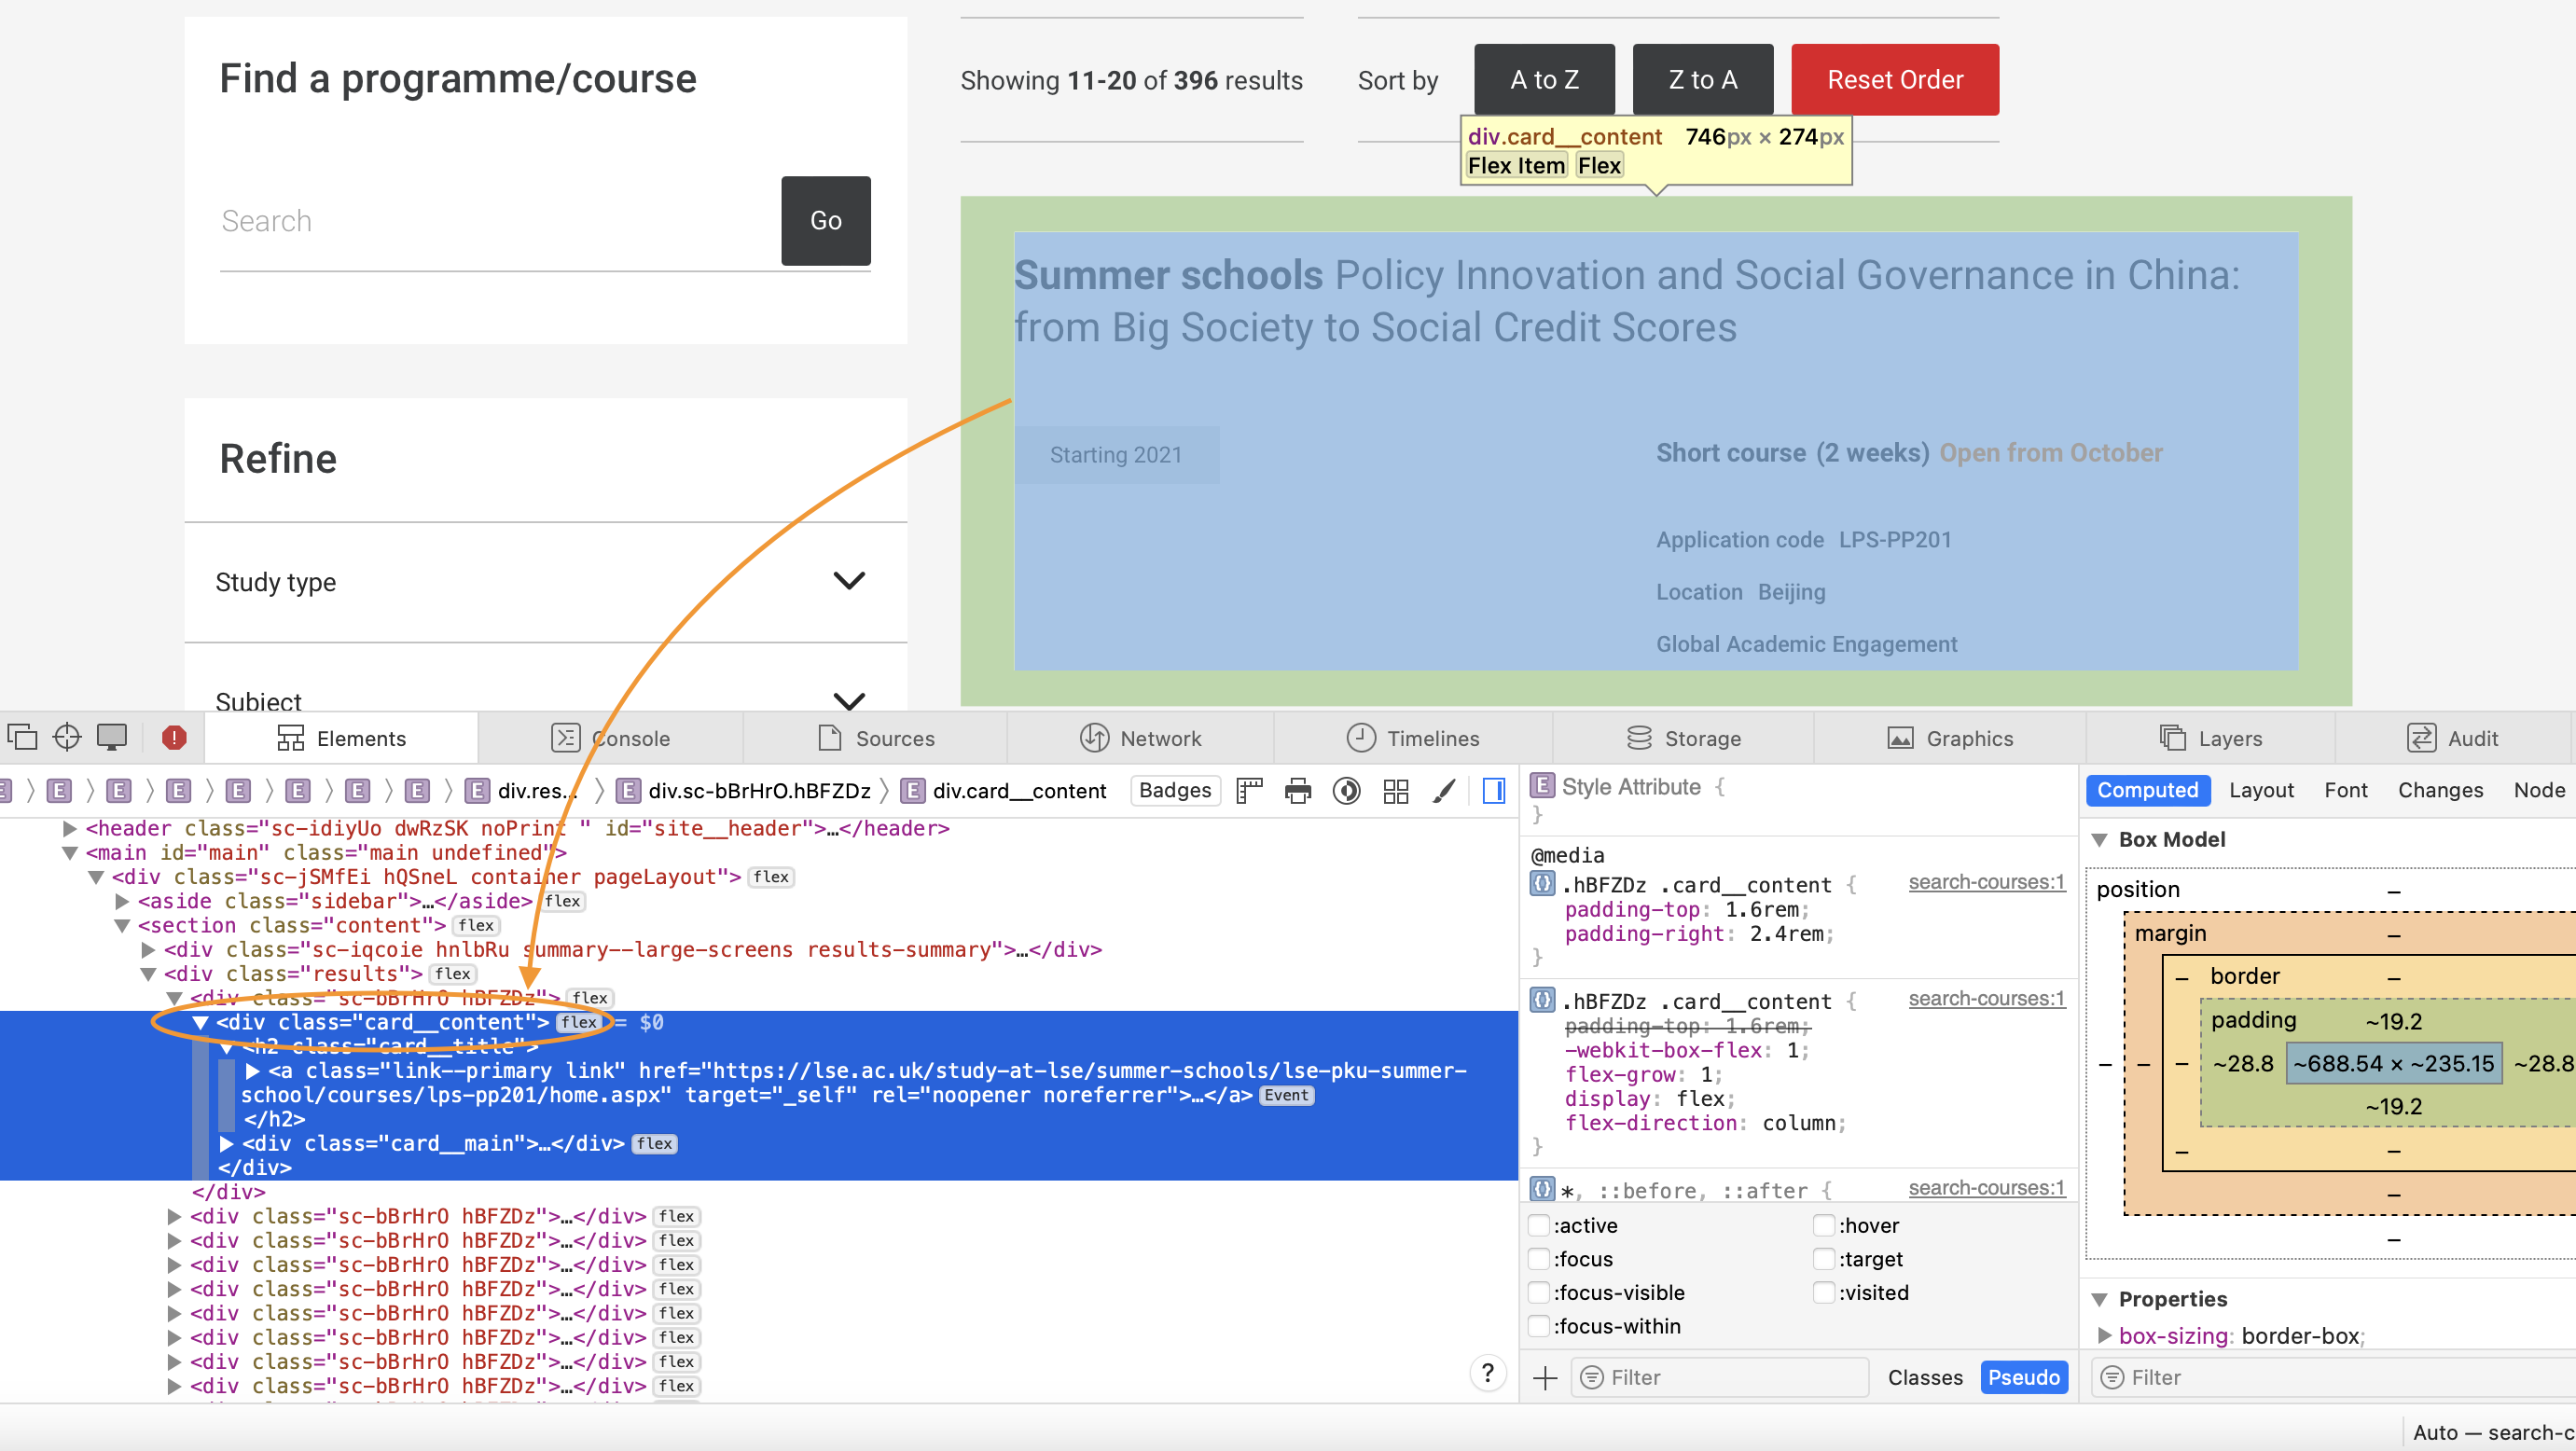

As you can see, the required information for every programme/course offered by LSE is stored within the `div` tag with a `card__content` class. 

Let's compare how we can get this element with CSS and XPath selectors.

## 2.2. CSS selectors

We know that we can pass the CSS Selector `div.card__content` to the `sel.css()` method to get this element:

In [12]:
# Extract the HTML code of the element with CSS selectors
pprint(sel.css('div.card__content').get()) # this gets the first element

('<div class="card__content"><h2 class="card__title"><a class="link--primary '
 'link" '
 'href="https://lse.ac.uk/study-at-lse/summer-schools/lse-pku-summer-school/courses/lps-pp201/home.aspx" '
 'target="_self" rel="noopener noreferrer"><span class="study-type">Summer '
 'schools</span> <!-- -->Policy Innovation and Social Governance in China: '
 'from Big Society to Social Credit Scores</a></h2><div '
 'class="card__main"><div class="main__body_l"><div '
 'class="card__infoTag">Starting 2021</div></div><div '
 'class="main__body_r"><div class="card__course__scope"><div '
 'class="scope__item"><span class="courseType">Short course</span><span '
 'class="duration">(2 weeks)</span><span class="availability">Open from '
 'October</span></div></div><div class="card__details"><div '
 'class="card__app-code"><span class="label">Application code</span> <!-- '
 '-->LPS-PP201</div><div class="card_location"><span '
 'class="label">Location</span> <!-- -->Beijing</div><div '
 'class="card_depa

To extract ALL the elements with this class, use the `getall()` method after the `sel.css()` method:

In [19]:
# The getall() method returns a list of strings
css_all_courses = sel.css('div.card__content')
print('There are', len(css_all_courses), 'courses on the page.') 

There are 10 courses on the page.


## 2.3 XPath

The syntax resembles a bit the way we would write a path to a file in the **Terminal**. You can use the familiar `..` and `/` symbols when navigating through the HTML code.

### 2.3.1 Absolute paths

A single forward slash `/` at the beginning of the path, for example, indicate that you're looking for elements within the current element. When we get a `sel` object, we are looking at the entire HTML code of the page, so the following syntax:

```xpath
/html/head/title
```

will return the tag that contains the title of the page:

```html
<title>Search courses | LSE Online Application System</title>
```


**How do I test that on the browser, without having to write Python code?**

On the Inspector, you can click on the 'Console' tab and type the following:

```javascript
$x('/html/head/title')
```

This will return an Array (similar to a Python list) that contains the element we are looking for. Take a look at the video below for a demonstration:

<div style="position: relative; padding-bottom: 59.375%; height: 0;"><iframe src="https://www.loom.com/embed/5c324141c4c24a6fb1ce7417c84ec422?sid=3d1cd528-fa33-4c55-ae25-adc0aeb6f0a6" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen style="position: absolute; top: 0; left: 0; width: 100%; height: 100%;"></iframe></div>

### 2.3.2 Relative paths

Just like with CSS selector, you don't need to specify the entire path to the element you are looking for. You can use the `//` symbol to indicate that you are looking for an element anywhere in the HTML code. For example, the following XPath selector:

```xpath
//title
```
would also return the `<title>` tag.

Give it a go! Open the browser console and type:

```javascript
$x('//title')
```

To confirm that you got the same result as before.

Like with CSS selectors, the search will not stop at the first element that matches the selector. It will return all the elements that match the selector.

### 2.3.3 Selecting elements by class

Instead of the `.` symbol used in CSS selectors, we use a mix of `contains()` and `@class` to select elements by class:

This is the syntax to select `<div>` elements with a `card__content` class:

```xpath
//div[contains(@class, 'card__content')]
```

In [18]:
# Extract the HTML code of all elements with XPath selectors
xpath_all_courses = sel.xpath('//div[contains(@class, "card__content")]')
print('There are', len(xpath_all_courses), 'courses on the page.')

There are 10 courses on the page.


### 2.3.4 Parents and children: the power of XPath

As mentioned above, XPath behaves a bit like a file system. We can use the `/..` symbol to get the parent of an element:

In [24]:
# Get the parent element of the div with the card__content class
pprint(sel.xpath('//div[contains(@class, "card__content")]//..').get())

('<div class="programmeCardstyled__ProgrammeCardStyled-sc-wl6zzq-0 '
 'jWHJzH"><div class="card__content"><h2 class="card__title"><a '
 'class="link--primary link" '
 'href="https://lse.ac.uk/study-at-lse/summer-schools/lse-pku-summer-school/courses/lps-ec210/home.aspx" '
 'target="_self" rel="noopener noreferrer"><span class="study-type">Summer '
 'schools</span> <!-- -->China and Global Financial Markets: New Risks and '
 'Challenges</a></h2><div class="card__main"><div class="main__body_l"><div '
 'class="card__infoTag">Starting 2021</div></div><div '
 'class="main__body_r"><div class="card__course__scope"><div '
 'class="scope__item"><span class="courseType">Short course</span><span '
 'class="duration">(2 weeks)</span><span class="availability">Open from '
 'October</span></div></div><div class="card__details"><div '
 'class="card__app-code"><span class="label">Application code</span> <!-- '
 '-->LPS-EC210</div><div class="card_location"><span '
 'class="label">Location</span> <!-

How do we get the children of an element? We use the `/*` symbol:

In [26]:
# Get the child elements of the div with the card__content class
pprint(sel.xpath('//div[contains(@class, "card__content")]/*').get())

('<h2 class="card__title"><a class="link--primary link" '
 'href="https://lse.ac.uk/study-at-lse/summer-schools/lse-pku-summer-school/courses/lps-ec210/home.aspx" '
 'target="_self" rel="noopener noreferrer"><span class="study-type">Summer '
 'schools</span> <!-- -->China and Global Financial Markets: New Risks and '
 'Challenges</a></h2>')


**You could not have done this with CSS selectors!**

## 2.4 More power to you: chaining CSS and XPath selectors

Note the different syntax for CSS and XPath selectors. CSS selectors are more straightforward, but XPath selectors are more powerful.

But here is what is really nice about scrapy selectors: you can chain CSS and XPath selectors together! This means that you can use a CSS selector to get an element, and then use an XPath selector to get its children.

To keep with example above, say you prefer to write `div.card__content` (CSS Selector) instead of `//div[contains(@class, 'card__content')]` (XPath) to get the `<div>` elements with a `card__content` class, you can do the following:


In [28]:
# Get the parent element of the div with the card__content class
pprint(sel.css('div.card__content').xpath('..').get())

('<div class="programmeCardstyled__ProgrammeCardStyled-sc-wl6zzq-0 '
 'jWHJzH"><div class="card__content"><h2 class="card__title"><a '
 'class="link--primary link" '
 'href="https://lse.ac.uk/study-at-lse/summer-schools/lse-pku-summer-school/courses/lps-ec210/home.aspx" '
 'target="_self" rel="noopener noreferrer"><span class="study-type">Summer '
 'schools</span> <!-- -->China and Global Financial Markets: New Risks and '
 'Challenges</a></h2><div class="card__main"><div class="main__body_l"><div '
 'class="card__infoTag">Starting 2021</div></div><div '
 'class="main__body_r"><div class="card__course__scope"><div '
 'class="scope__item"><span class="courseType">Short course</span><span '
 'class="duration">(2 weeks)</span><span class="availability">Open from '
 'October</span></div></div><div class="card__details"><div '
 'class="card__app-code"><span class="label">Application code</span> <!-- '
 '-->LPS-EC210</div><div class="card_location"><span '
 'class="label">Location</span> <!-

Say I want to obtain the text of the tag within the `<div>` with a `card__content` class. I could choose to use a CSS selector (`::text`) or the equivalent in XPath selector (`//text()`):

In [31]:
# CSS selector then XPath selector then CSS selector
print(sel.css('div.card__content').xpath('*').css('::text').get())

Summer schools


In [34]:
# CSS selector then XPath selector
print(sel.css('div.card__content').xpath('* //text()').get())

Summer schools


Of course, we can also do this purely with XPath selectors, but some people might find it looks more convoluted:

In [36]:
# Get the children of the div with the card__content class
print(sel.xpath('//div[contains(@class, "card__content")]/* //text()').get())

Summer schools


In the end, it is up to you to decide which one you prefer.

# 3. Parsing the first course

After a thourough inspection of the HTML structure of the page, we can come up with the following plan to collect the information we need:


| Element Description                 | CSS Selector                          | XPath Selector                                |
|------------------------------------|--------------------------------------|-----------------------------------------------|
| "Summer schools" text               | `.study-type`                        | `//span[@class='study-type']`                 |
| Course title link                   | `.card__title a`                     | `//h2[@class='card__title']//a`               |
| "Starting 2021" text               | `.card__infoTag`                     | `//div[@class='main__body_l']//div[@class='card__infoTag']` |
| "Short course" text (scope)        | `.courseType`                        | `//span[@class='courseType']`                 |
| "(2 weeks)" duration text (scope)  | `.duration`                          | `//span[@class='duration']`                   |
| "Open from October" text (scope)   | `.availability`                      | `//span[@class='availability']`               |
| "Application code" label           | `.card__app-code .label`             | `//span[@class='label' and text()='Application code']` |
| Location label                     | `.card_location .label`              | `//span[@class='label' and text()='Location']` |
| Location value (Beijing)           | `.card_location`                     | `//div[@class='card_location']`               |
| Department value (Global Academic Engagement) | `.card_department`        | `//div[@class='card_department']`           |
| "Summer schools" text (details)    | `.card__details .sc-gsnTZi`         | `//div[@class='card__details']//div[@class='sc-gsnTZi']` |


A dictionary is a good way to store this information, let's start with an empty one and add the information we need as we go along:

In [93]:
course_data = {}

Let's start with the first course:

In [37]:
first_course = sel.css('div.card__content')[0]

Note one very important thing about the `first_course` variable: it is a `Selector` object, not a string. Therefore, it contains other methods and attributes inside it.

**Why is that useful?** 

We can treat this object as our HTML code, and use the same methods we used to get the `first_course` object to get the information we need from it. We don't need to scrape the entire page again to get the information we need.


## 3.1 Extract the course title

To illustrate the observation above, let's get the title of _this particular course_, we can use the same CSS selector we used to get the `first_course` object:

In [70]:
first_course.css('h2.card__title a::text')

[<Selector query="descendant-or-self::h2[@class and contains(concat(' ', normalize-space(@class), ' '), ' card__title ')]/descendant-or-self::*/a/text()" data=' '>,
 <Selector query="descendant-or-self::h2[@class and contains(concat(' ', normalize-space(@class), ' '), ' card__title ')]/descendant-or-self::*/a/text()" data='China and Global Financial Markets: N...'>]

This further returns a list of `Selector` objects. I could get their individual text by using the `getall()` method:

In [71]:
first_course.css('h2.card__title a::text').getall()

[' ', 'China and Global Financial Markets: New Risks and Challenges']

Because the second element in the list is the one we are looking for, we can use Python's list indexing to get it and therefore, finally get the text that corresponds to the title of the course:

In [72]:
first_course.css('h2.card__title a::text').getall()[1]

'China and Global Financial Markets: New Risks and Challenges'

**Is there a neater way to do that?**

Yes, let's move to XPath selectors. It allows us to index the list directly in the selector:

In [112]:
first_course.css('h2.card__title').xpath('a/text()[2]').get()

'China and Global Financial Markets: New Risks and Challenges'

**Wraping up**

After much exploring, we are now ready to store the information we need in our dictionary:

In [106]:
course_data['title'] = first_course.css('h2.card__title').xpath('a/text()[2]').get()

## 3.2 Extract other data from the course card

Using a similar logic, we would experiment with CSS and XPath as needed to get the other information we need:

In [118]:
course_data['start_date'] = first_course.css('div.card__infoTag::text').get()

course_data['duration'] = first_course.css('span.duration::text').get()

course_data['location'] = first_course.xpath("//div[@class='card_location']//text()[2]").get()

course_data['department'] = first_course.css('div.card_department::text').get()

course_data['application_code'] = first_course.xpath("//div[@class='card__app-code']//text()[2]").get()

course_data['course_type'] = first_course.css('span.courseType::text').get()

course_data['availability'] = first_course.css('span.availability::text').get()

Let's check that we have all the information we need:

In [119]:
pprint(course_data)

{'application_code': 'LPS-EC210',
 'availability': 'Open from October',
 'course_type': 'Short course',
 'department': 'Global Academic Engagement',
 'duration': '(2 weeks)',
 'location': 'Beijing',
 'start_date': 'Starting 2021',
 'title': 'China and Global Financial Markets: New Risks and Challenges'}


## 3.3 Create a custom function to extract course data

You will need to repeat this step many times to get the information for all the courses. Ideally, we should not repeat ourselves and create a function that does this for us.

Let's create a function that takes a `Selector` object as an argument and returns a dictionary with the information we need:

In [123]:
def parse_course_data(course):
    """
    Extracts course data from a Selector object and returns a dictionary with the data.
    """

    course_data = {}
    course_data['title'] = course.css('h2.card__title').xpath('a/text()[2]').get()
    course_data['start_date'] = course.css('div.card__infoTag::text').get()
    course_data['duration'] = course.css('span.duration::text').get()
    course_data['location'] = course.xpath("//div[@class='card_location']//text()[2]").get()
    course_data['department'] = course.css('div.card_department::text').get()
    course_data['application_code'] = course.xpath("//div[@class='card__app-code']//text()[2]").get()
    course_data['course_type'] = course.css('span.courseType::text').get()
    course_data['availability'] = course.css('span.availability::text').get()
    return course_data

Then, let's test that it works as expected by running it on the `first_course` object:

In [124]:
parse_course_data(first_course)

{'title': 'China and Global Financial Markets: New Risks and Challenges',
 'start_date': 'Starting 2021',
 'duration': '(2 weeks)',
 'location': 'Beijing',
 'department': 'Global Academic Engagement',
 'application_code': 'LPS-EC210',
 'course_type': 'Short course',
 'availability': 'Open from October'}

Perfect!

## 3.3 Putting it all together

Note that, unless you are writing a tutorial such as this notebook, you don't need to keep track of all the painstaking steps you took to get the information you need. 

The process shown above is typically how you would go about scraping a page. You would start by inspecting the elements in the page, and then use CSS and XPath selectors to get the information you need. Then you would open code chunks in your notebook and test the selectors you came up with until you get the information you need.

BUT, as soon as you are happy with the selectors you came up with, you can clear up your notebook and make your code and thought process more concise.

Below I show you how I would organise the markdown and code chunks of my Jupyter notebook for the purpose of reporting (or for an assignment) and not for teaching purposes:



-----
<details><summary>Click here to see example of a Jupyter Notebook ready for a report</summary>


```markdown
**CANDIDATE NUMBER:** 29292

**OBJECTIVE:** Collect information on all the courses offered by LSE

**DATE:** 22 October 2023

```

```markdown
# ⚙️ Set up

Import required libraries

```

```python
import requests
import scrapy

import pandas as pd
```

```markdown
**Custom functions**

I will use these functions to extract the information I need from the HTML code of the page.

```

```python
def parse_course_data(course):
    """
    Extracts course data from a Selector object and returns a dictionary with the data.
    """

    # Check that course is a valid Selector object
    if not isinstance(course, scrapy.selector.Selector):
        raise TypeError('course must be a Selector object')

    course_data = {}
    course_data['title'] = course.css('h2.card__title').xpath('a/text()[2]').get()
    course_data['start_date'] = course.css('div.card__infoTag::text').get()
    course_data['duration'] = course.css('span.duration::text').get()
    course_data['location'] = course.xpath("//div[@class='card_location']//text()[2]").get()
    course_data['department'] = course.css('div.card_department::text').get()
    course_data['application_code'] = course.xpath("//div[@class='card__app-code']//text()[2]").get()
    course_data['course_type'] = course.css('span.courseType::text').get()
    course_data['availability'] = course.css('span.availability::text').get()
    return course_data
```

```markdown
# 1. Load the page and get the HTML

```

```python
base_url = 'https://www.lse.ac.uk/programmes/search-courses?pageIndex=1'

response = requests.get(base_url)

# Checking that the request was successful
print(response.status_code)
```

```markdown
# 2. Select course cards

All course cards are stored within a <div> tag with a `card__content` class. I will extract them all to a list, then later I will invoke my custom function to extract the information I need from each card.

```

```python
# Create a Selector object from the HTML code
sel = scrapy.Selector(text=response.text)

# Get all the course cards
course_cards = sel.css('div.card__content')
```

```markdown
Checking that I got all the course cards:

```

```python
len(course_cards)
```

```markdown
It matches what I see on the page, so I can move on to the next step.
```

```markdown
# 3. Extract the information I need from each course card

My custom function `parse_course_data()` takes a Selector object as an argument and returns a dictionary with the information I need. For example, here is the output for the first course card:

```

```python
parse_course_data(course_cards[0])
```

```markdown
I will now apply this function to all the course cards and store the results in a list using a list comprehension:

```

```python
course_data = [parse_course_data(course) for course in course_cards]
```

```markdown
# 4. Convert the list of dictionaries to a DataFrame

```

```python
df = pd.DataFrame(course_data)
df.head()
```

...

</details>

---

# Pagination

As you will have seen on the website, there are multiple pages with courses. We can see how many pages there are by looking at the pagination at the bottom of the page: there are 40 pages in total. Our function currently works just for one page, but it is easy to adapt it to work for all the pages. All we need to do is tweak the `pageIndex` parameter in the URL.

That is, where we currently have:


```html
https://www.lse.ac.uk/programmes/search-courses?pageIndex=1
```

we could have:

```html
https://www.lse.ac.uk/programmes/search-courses?pageIndex=2
```

to scrape the second page, and so on.

## 4.1 Getting the number of pages

A quick inspection of the pagination at the bottom of the page shows that the number of pages is stored in the following path:

In [134]:
sel.css('ul.pager > li.last > button > span::text').get()

'40'

I would then convert this to an integer, store it in a variable called `num_pages`. Then I can write a for loop to scrape all the pages:

In [143]:
base_url = 'https://www.lse.ac.uk/programmes/search-courses?pageIndex='

### Get the total number of pages

response = requests.get(base_url + '1')
sel = Selector(text = response.text)
num_pages = int(sel.css('ul.pager > li.last > button > span::text').get())
print('Total number of pages:', num_pages)

# Create an empty list to store the results

all_courses = []

# Loop through all pages
# Note that we have to adjust the range() function to start from 1, not 0
for page_num in range(1, num_pages+1):

    # Build the new URL and send the request
    url = base_url + str(page_num)
    response = requests.get(url)

    # Check the status code, 200 means OK, anything else means something went wrong
    if not response.status_code == 200:
        print('Something went wrong for page', str(page_num), ', status code:', response.status_code)
        print('Stopping here!')
        break
    else:
        print('Everything is OK for page', str(page_num), ', status code:', response.status_code)

    # Create a Selector object from the HTML code
    sel = Selector(text = response.text)

    # Extract all courses on the page
    course_cards = sel.css('div.card__content')

    # Loop through the courses
    course_data = [parse_course_data(course) for course in course_cards]

    # Add the results to the list
    all_courses.extend(course_data)


Total number of pages: 40
Everything is OK for page 1 , status code: 200
Everything is OK for page 2 , status code: 200
Everything is OK for page 3 , status code: 200
Everything is OK for page 4 , status code: 200
Everything is OK for page 5 , status code: 200
Everything is OK for page 6 , status code: 200
Everything is OK for page 7 , status code: 200
Everything is OK for page 8 , status code: 200
Everything is OK for page 9 , status code: 200
Everything is OK for page 10 , status code: 200
Everything is OK for page 11 , status code: 200
Everything is OK for page 12 , status code: 200
Everything is OK for page 13 , status code: 200
Everything is OK for page 14 , status code: 200
Everything is OK for page 15 , status code: 200
Everything is OK for page 16 , status code: 200
Everything is OK for page 17 , status code: 200
Everything is OK for page 18 , status code: 200
Everything is OK for page 19 , status code: 200
Everything is OK for page 20 , status code: 200
Everything is OK for pa

Check that it worked:

In [144]:
len(all_courses)

396

PERFECT! It matches what I see on the page.

## 4.2 Putting it all together

I will typically want this as a DataFrame, so I will convert `all_course`:

In [145]:
df = pd.DataFrame(all_courses)
df.head()

title     start_date  \
0  Policy Innovation and Social Governance in Chi...  Starting 2021   
1  China and Global Financial Markets: New Risks ...  Starting 2021   
2  Human Resource Management in Multinational Cor...  Starting 2021   
3                            Principles of Marketing  Starting 2021   
4  The Political Economy of Urbanisation in China...  Starting 2021   

    duration location                  department application_code  \
0  (2 weeks)  Beijing  Global Academic Engagement        LPS-PP201   
1  (2 weeks)  Beijing  Global Academic Engagement        LPS-PP201   
2  (2 weeks)  Beijing  Global Academic Engagement        LPS-PP201   
3  (2 weeks)  Beijing  Global Academic Engagement        LPS-PP201   
4  (2 weeks)  Beijing  Global Academic Engagement        LPS-PP201   

    course_type       availability  
0  Short course  Open from October  
1  Short course  Open from October  
2  Short course  Open from October  
3  Short course  Open from October  
4  Short course  Open from October

Now I can start doing my analysis!

# Thinking ahead

## What to do next

Keep in mind that you could use the `url` variable to scrape the course descriptions from all the course pages. You could also scrape the course details from the course pages, such as the course convenor, level, syllabus, assessment methods and so on. 


**Happy scraping!**